In [1]:
%load_ext autoreload
%autoreload 2

from model.autoregressive import ARModel
from model import LinearModel
from filtering.colkf import ColKF
from filtering.enkf import EnKF
from utils.plotter import Plotter

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
generator = np.random.default_rng(0)

N = 40
T0 = 0
T = 10
dt = 0.01
D = 2

x0 = np.array([np.pi / 2, 0.5])
x0_cov = 0.1 * np.eye(D)

b0 = np.zeros(D)
b0_cov = 0.001 * np.eye(D)

R = lambda _: 0.05 * np.eye(D)
Q_X = lambda _: 0.001 * np.eye(D)
Q_b = lambda _: 0.00001 * np.eye(D)

b_true = -0.01 * np.ones(D)

M = lambda _: np.array([[0, 1], [-2, -0.5]])
H = lambda _: np.eye(D)

A = lambda _: np.diag([1] * 2)

<Axes: xlabel='$t$'>

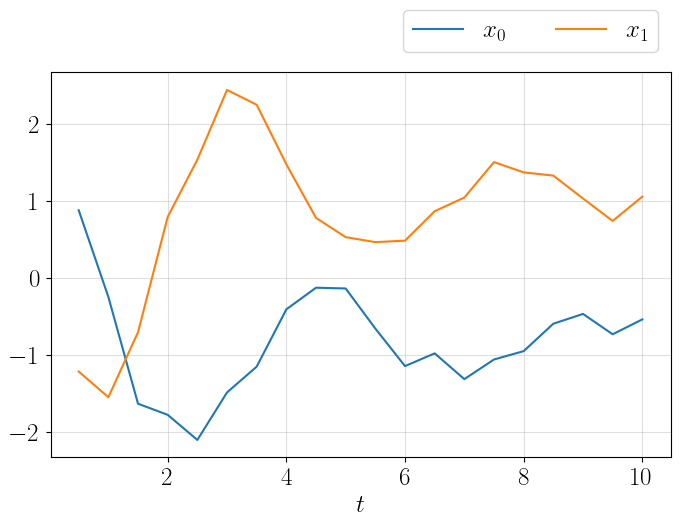

In [3]:
linear_model = LinearModel(x0, dt, M, H, Q_X, R, generator, solver="rk4")
linear_model.discrete_forcing = lambda *_: b_true
times, states = linear_model.integrate(T0, T)
linear_model.reset_model(x0)

# Generate observations with noise
assimilation_step = 0.5
assimilation_times = np.linspace(T0 + assimilation_step, T, int(T / assimilation_step))
observed = np.zeros((D, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / dt)
    observed[:, i] = linear_model.observe(states[:, k], add_noise=True)

Plotter.mplot(
    assimilation_times,
    [observed[i, :] for i in range(D)],
    ["$x_0$", "$x_1$"],
    xlabel="$t$",
    ylabel="",
    figsize="standard",
)

In [4]:
linear_model.discrete_forcing = lambda *_: np.zeros(D)

enkf = EnKF(linear_model, x0, x0_cov, N, generator=generator)
results = enkf.filter(assimilation_times, observed)
results.figsize = "horizontal"

100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


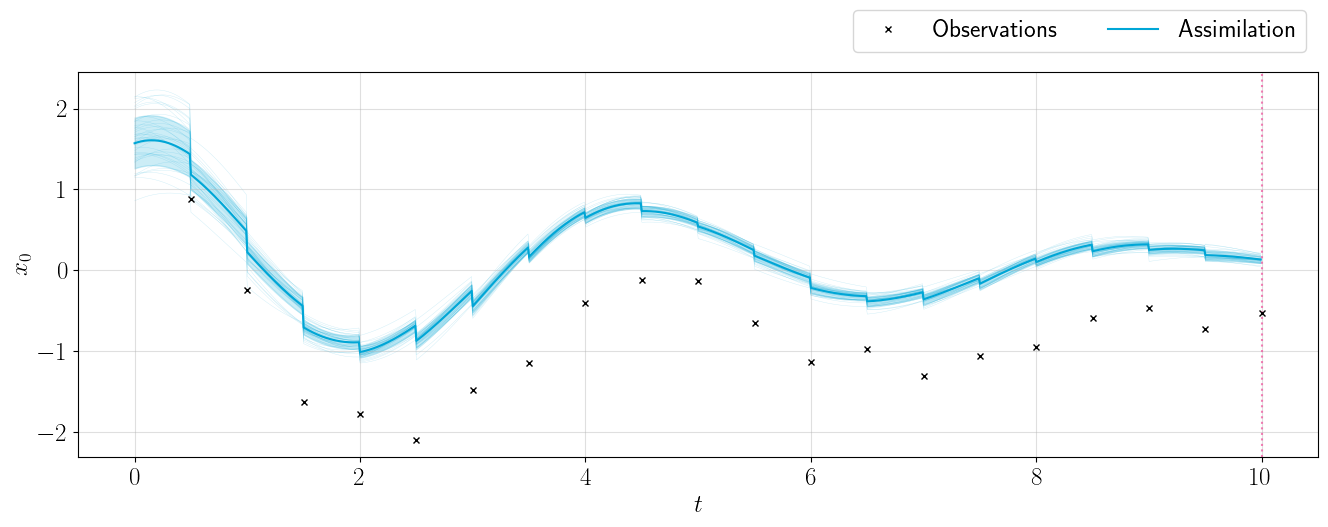

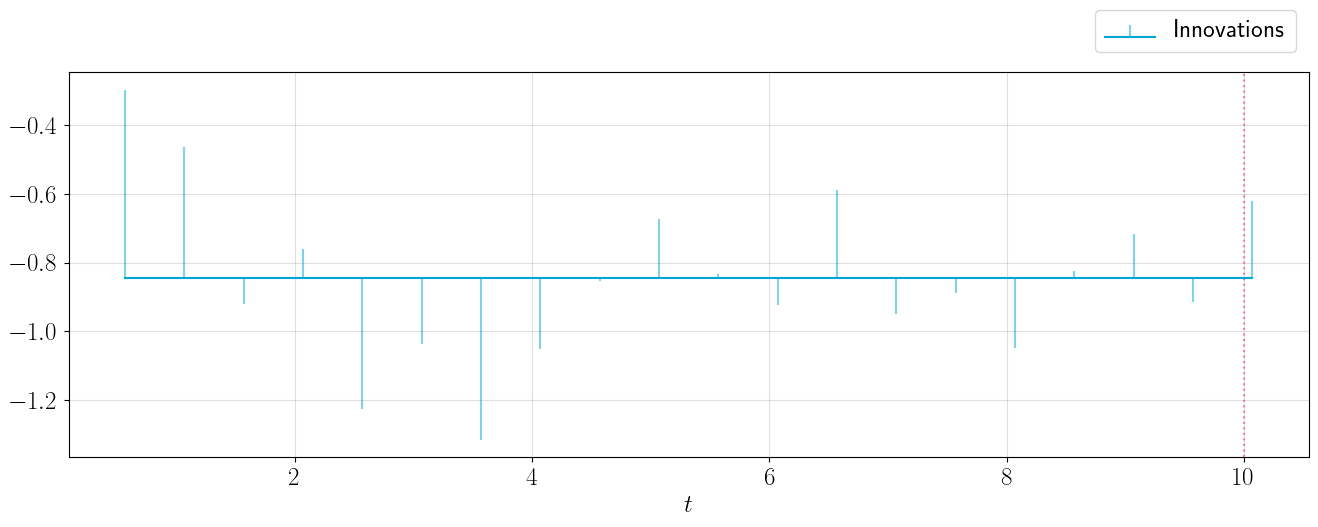

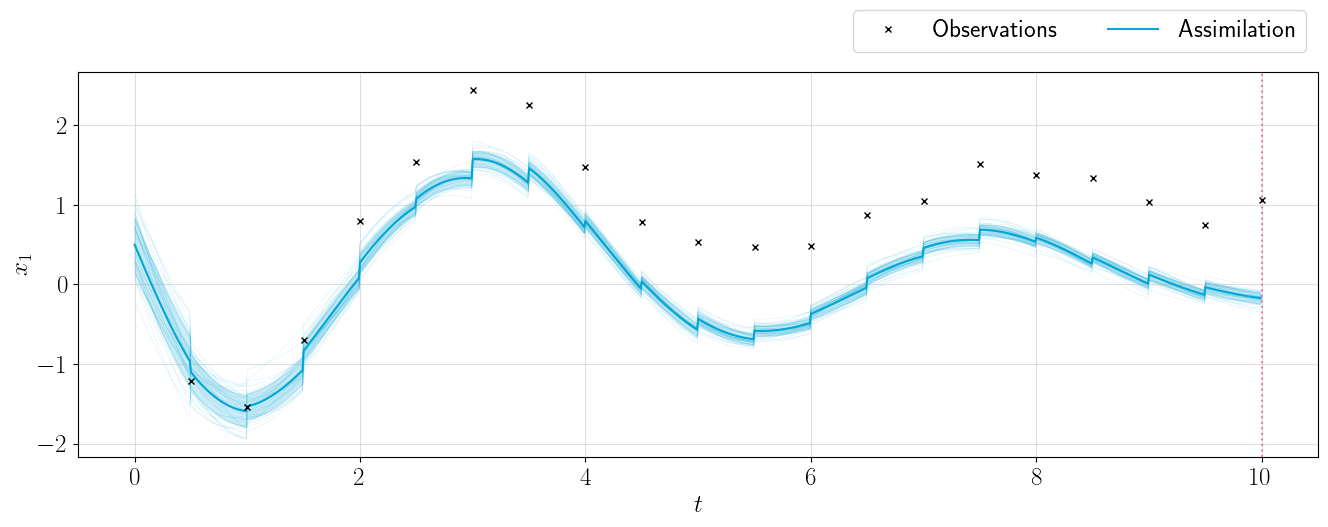

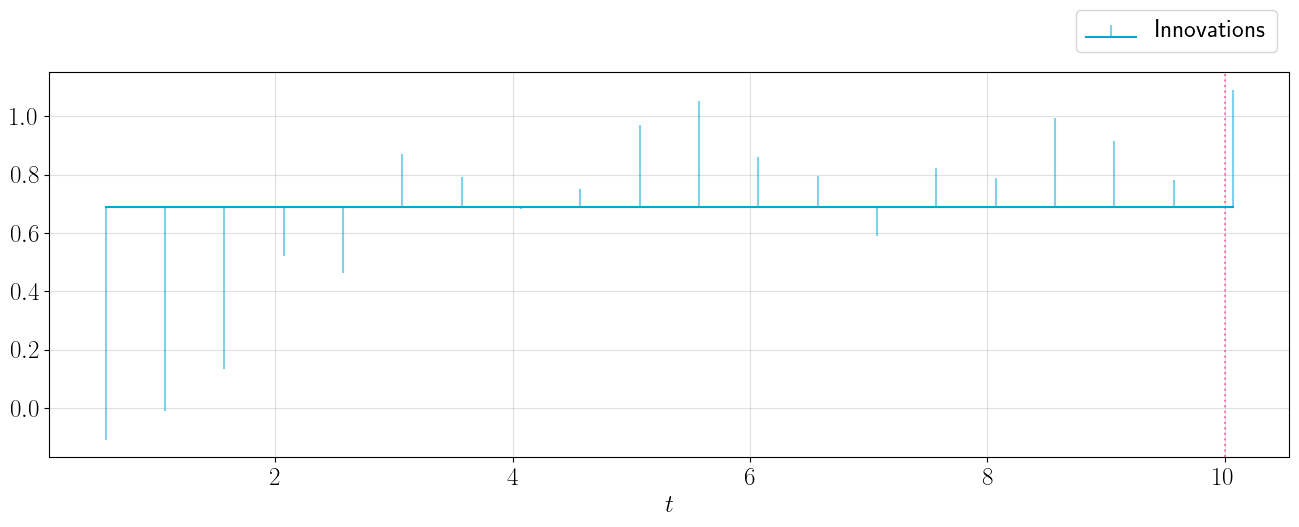

In [5]:
for i in range(results.model.n_states):
    results.plot_filtering(i, True, True)
    results.plot_innovations(i)

In [6]:
H_ar = lambda _: np.zeros((0, b0.shape[0]))
ar_model = ARModel(A, H_ar, b0, dt, Q_b, generator, stochastic_propagation=False)
colkf = ColKF(ar_model, enkf, x0, x0_cov, b0, b0_cov, feedback=True)
results_col = colkf.filter(assimilation_times, observed)
results_col.figsize = "horizontal"

100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


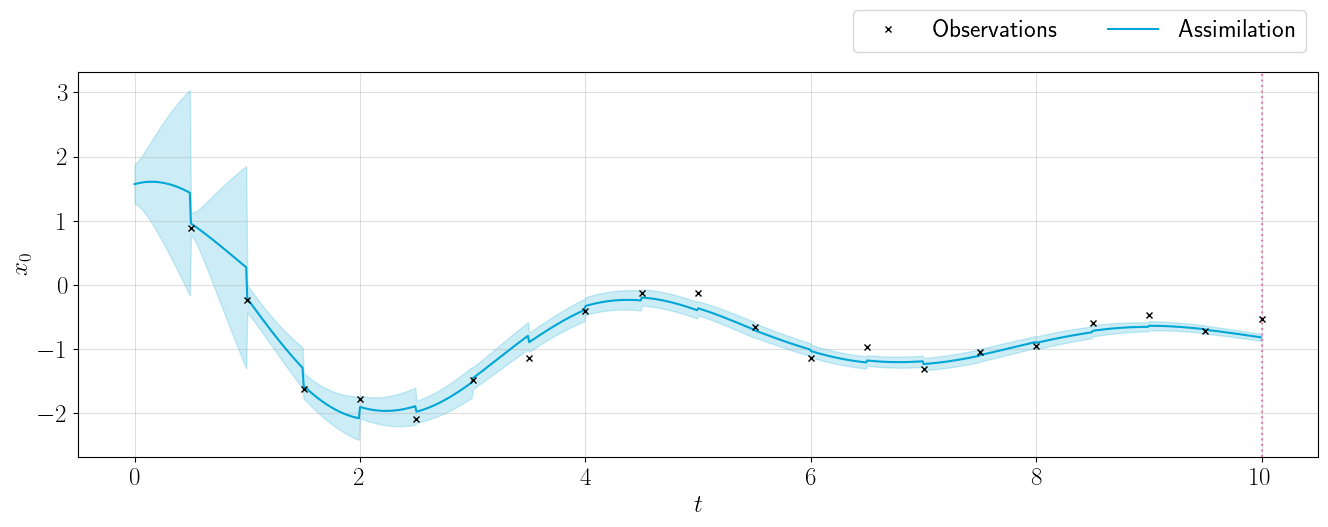

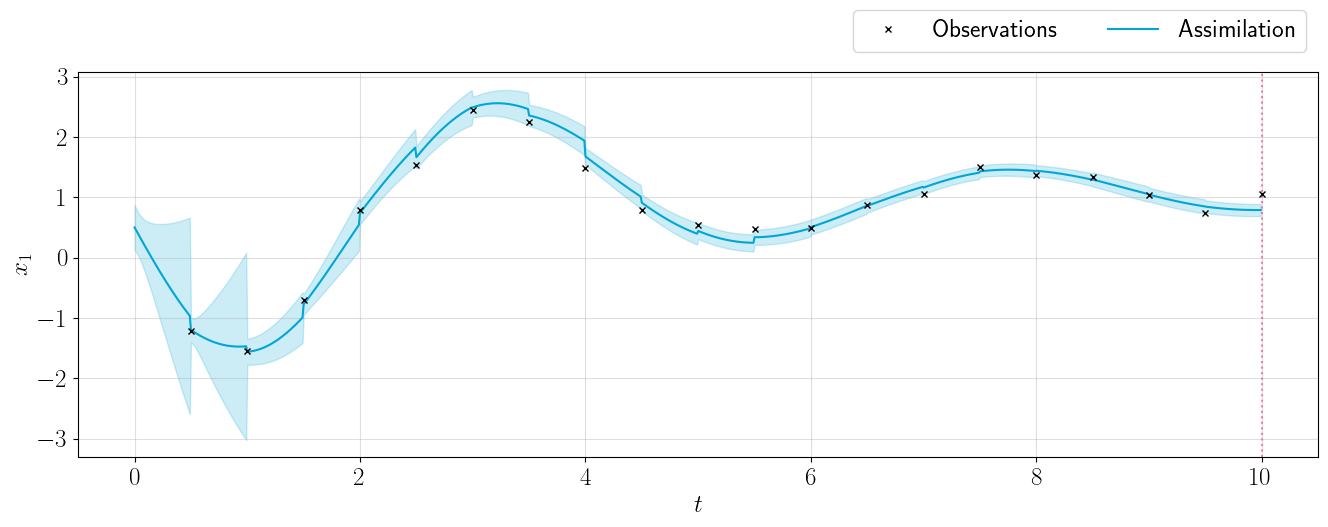

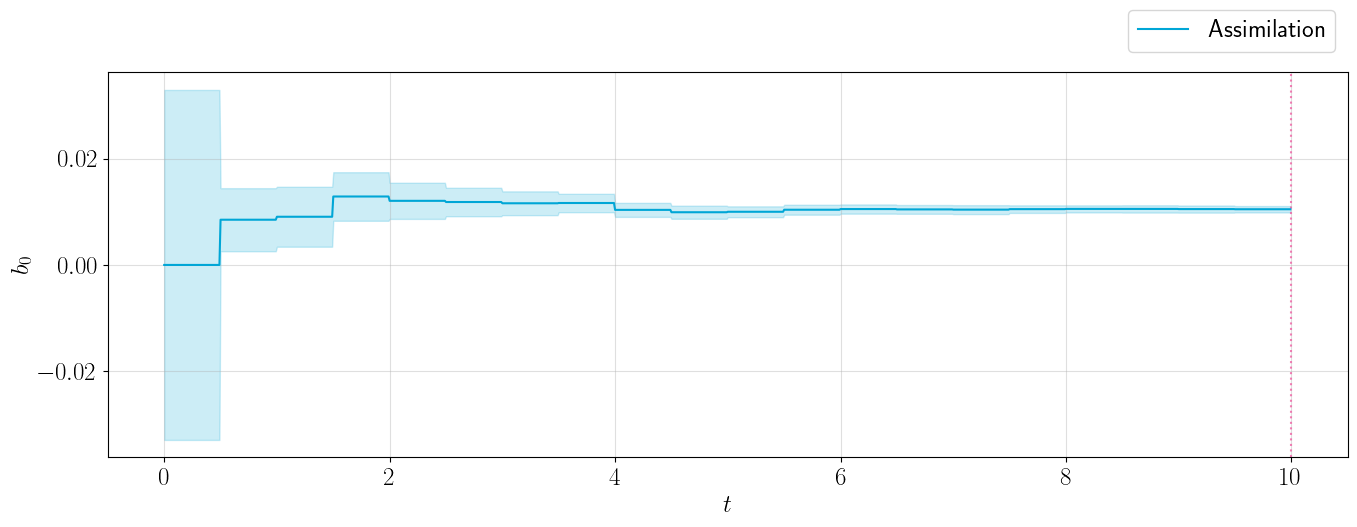

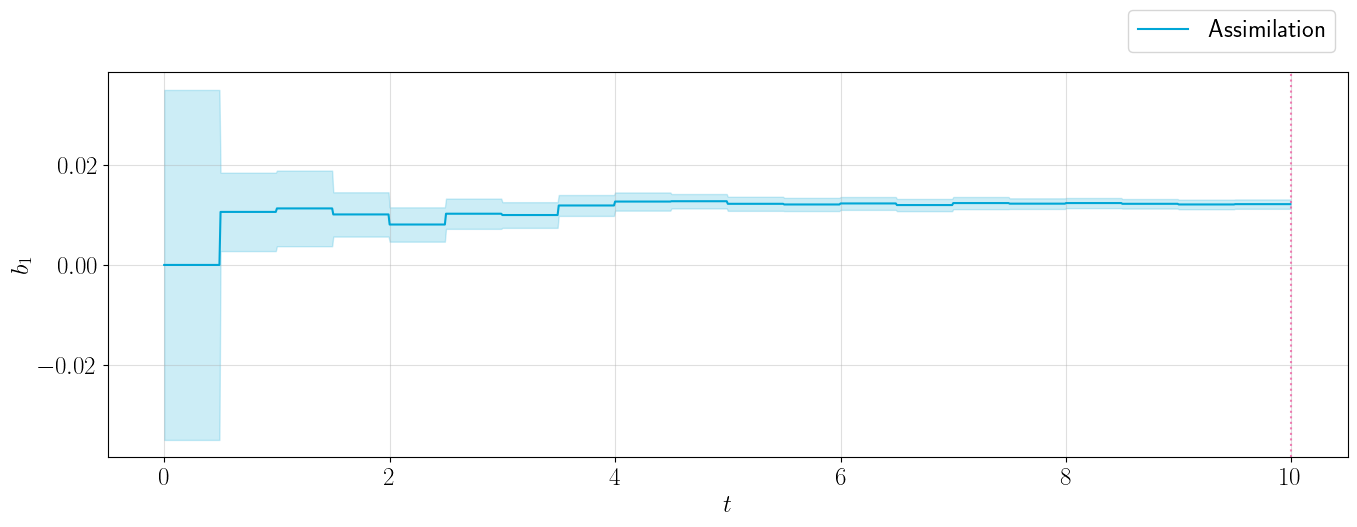

In [7]:
states = [0, 1]
for i in range(results_col.model.n_states):
    results_col.plot_filtering(
        i, False, True, only_state=False if i in states else True
    )